## Run a single example of the calibration for a certain set of parameters

In [4]:
include("ms_calibration.jl")

# demonstrate that we have achieve >99.99% fidelity with ideal parameters
detuning_khz = 10
pi_time_μs = 5
@time ms_fidelity(detuning_khz, pi_time_μs, detuning_khz, pi_time_μs)

  0.144193 seconds (353.88 k allocations: 18.813 MiB, 95.76% compilation time)


0.9999678828839385

In [44]:
include("ms_calibration.jl")
import PyPlot
const plt = PyPlot;

detuning_khz = 10
pi_time_μs = 5
initial_guess = [detuning_khz*0.8, pi_time_μs*0.8]
tspan_ideal = 0:0.1:200

N = 50
tspan_experiment = 0:20:200

@time res = ms_calibration(detuning_khz, pi_time_μs, initial_guess, N, tspan_ideal, tspan_experiment)

ideal = res["ideal_curve"]
ideal_fit_params = res["ideal_fit_params"]
experimental = res["experimental_data"]
learned = res["learned_curve"]
learned_fit_params = res["learned_fit_params"]

mean_error = mean(abs.(ideal_fit_params - learned_fit_params))
relative_error = mean_error / mean(ideal_fit_params)

  1.611101 seconds (18.13 M allocations: 565.833 MiB, 5.75% gc time, 37.53% compilation time)


0.009852088241150152

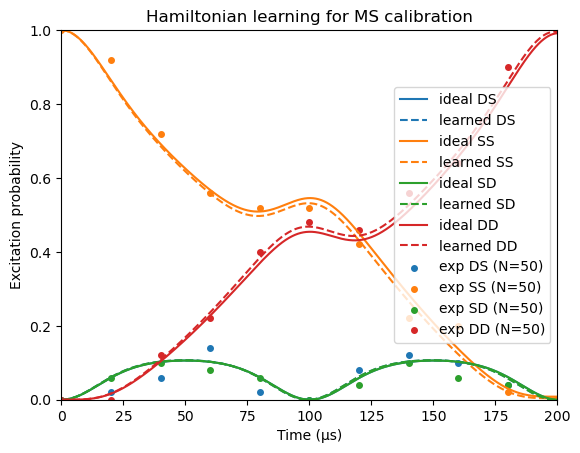

ideal fit parameters θ₁=10.0 kHz, θ₂=5.0 μs
learned fit parameters θ₁=10.0678 kHz, θ₂=4.92 μs
fit parameters relative error=0.0099


In [45]:
plt.figure()
for state in keys(experimental[1])
    plt.plot(tspan_ideal, getindex.(ideal, state), "-", label="ideal $state")
    plt.plot(tspan_ideal, getindex.(learned, state), "--", label="learned $state", color=plt.gca().lines[end].get_color())
    plt.scatter(tspan_experiment, getindex.(experimental, state), label="exp $state (N=$(N))", s=16, color=plt.gca().lines[end].get_color())
end

println("ideal fit parameters θ₁=$(round(ideal_fit_params[1]; digits=4)) kHz, θ₂=$(round(ideal_fit_params[2]; digits=4)) μs")
println("learned fit parameters θ₁=$(round(learned_fit_params[1]; digits=4)) kHz, θ₂=$(round(learned_fit_params[2]; digits=4)) μs")
println("fit parameters relative error=$(round(relative_error; digits=4))")

plt.title("Hamiltonian learning for MS calibration")
plt.xlim(tspan_ideal[1], tspan_ideal[end])
plt.ylim(0, 1)
plt.xlabel("Time (μs)")
plt.ylabel("Excitation probability")
plt.legend(loc="center right");

## Test the average error of the technique as a function of N

In [46]:
include("ms_calibration.jl")

n_repetitions = 20
n_shots_list = [5, 10, 25, 50, 100, 250, 500, 1000]

tspan_ideal = 0:0.1:200
tspan_experiment = 0:20:200

relative_error_results = Dict()
fidelities = Dict()
for n_shots in n_shots_list 
    print("Running for n_shots=$(n_shots)")
    relative_error_results[n_shots] = []
    fidelities[n_shots] = []
    for i = 1:n_repetitions
        print(".")
        actual_detuning_khz = 10
        actual_pi_time_μs = 5
        initial_guess = [actual_detuning_khz*0.8, actual_pi_time_μs*0.8]
        res = ms_calibration(
            actual_detuning_khz,
            actual_pi_time_μs,
            initial_guess,
            n_shots,
            tspan_ideal,
            tspan_experiment)

        ideal = res["ideal_curve"]
        ideal_fit_params = res["ideal_fit_params"]
        experimental = res["experimental_data"]
        learned = res["learned_curve"]
        learned_fit_params = res["learned_fit_params"]

        # calculate relative error in learned fit parameters
        mean_error = mean(abs.(ideal_fit_params - learned_fit_params))
        relative_error = mean_error / mean(ideal_fit_params)
        push!(relative_error_results[n_shots], relative_error)
        
        # calculate the resulting error in MS-gate fidelity
        learned_detuning_khz = learned_fit_params[1]
        learned_pi_time_μs = learned_fit_params[2]
        fidelity = ms_fidelity(actual_detuning_khz, actual_pi_time_μs, learned_detuning_khz, learned_pi_time_μs)
        push!(fidelities[n_shots], fidelity)
    end
    println(" complete!")
end

Running for n_shots=5.................... complete!
Running for n_shots=10.................... complete!
Running for n_shots=25.................... complete!
Running for n_shots=50.................... complete!
Running for n_shots=100.................... complete!
Running for n_shots=250.................... complete!
Running for n_shots=500.................... complete!
Running for n_shots=1000.................... complete!


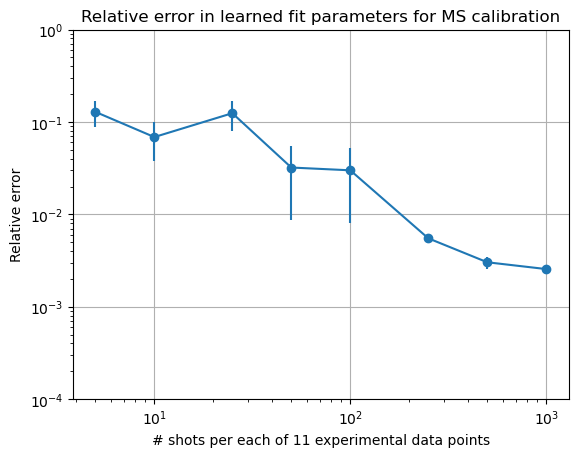

In [47]:
import PyPlot
const plt = PyPlot;

relative_error_means = []
relative_error_stderrs = []
for n_shots in n_shots_list
    push!(relative_error_means, mean(relative_error_results[n_shots]))
    push!(relative_error_stderrs, Statistics.std(relative_error_results[n_shots]) / sqrt(length(relative_error_results[n_shots])))
end

plt.figure()
plt.errorbar(x=n_shots_list, y=relative_error_means, yerr=relative_error_stderrs, linestyle="-", marker="o")

plt.title("Relative error in learned fit parameters for MS calibration")
plt.ylim(1e-4, 1)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("# shots per each of $(length(tspan_experiment)) experimental data points")
plt.ylabel("Relative error")
plt.grid();

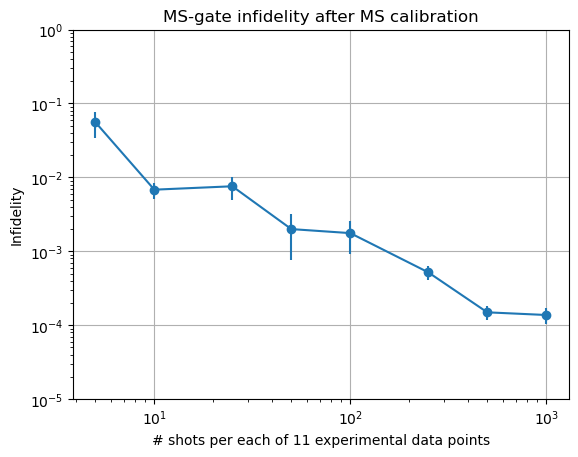

In [48]:
import PyPlot
const plt = PyPlot;
using Statistics

fidelity_means = []
fidelity_stderrs = []
for n_shots in n_shots_list
    push!(fidelity_means, mean(fidelities[n_shots]))
    push!(fidelity_stderrs, Statistics.std(fidelities[n_shots]) / sqrt(length(fidelities[n_shots])))
end

plt.figure()
plt.errorbar(x=n_shots_list, y=1 .- fidelity_means, yerr=fidelity_stderrs, linestyle="-", marker="o")

plt.title("MS-gate infidelity after MS calibration")
plt.ylim(1e-5, 1)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("# shots per each of $(length(tspan_experiment)) experimental data points")
plt.ylabel("Infidelity")
plt.grid();

## Print the raw result data

In [49]:
print(relative_error_results)

Dict{Any, Any}(5 => Any[0.015500648188411563, 0.03880145169880921, 0.05535345646605349, 0.024236230148522667, 0.07011201747622191, 0.021628744988838437, 0.024901623770532073, 0.06900211059743609, 0.0789271956803256, 0.015359759610713179, 0.04824111673497094, 0.04619667254032293, 0.4151253705684323, 0.13626823770558913, 0.34997279709715284, 0.608749035362829, 0.026723550812274215, 0.004665377914320364, 0.025944166607207345, 0.4942736231053516], 50 => Any[0.0038464497240973117, 0.010082852039078638, 0.01311999641091841, 0.016489405591356508, 0.004912225559077636, 0.0028348597442966177, 0.002261322005840505, 0.003170068356606966, 0.00947878129250969, 0.01411497812443076, 0.01254076072041658, 0.007388797430032726, 0.009248467600874536, 0.006441718421852845, 0.4777331776165745, 0.015643999654862385, 0.012654719971370021, 0.004923479529753886, 0.007490778113849453, 0.007431532800172924], 500 => Any[0.001661068594634448, 0.0030121983673403463, 0.003124848496727791, 0.005117161570136612, 0.000

In [50]:
print(fidelities)

Dict{Any, Any}(5 => Any[0.9956847692886659, 0.9937571909723486, 0.9627657197822708, 0.991186263017948, 0.9817147918411734, 0.997348663281946, 0.9970543392878024, 0.9161976529163143, 0.9702593598321709, 0.9985836864054365, 0.9904643760293551, 0.9639512862829808, 0.6843121321217949, 0.9180052792394788, 0.6930789528668263, 0.8537903191731435, 0.9972166203095447, 0.9997188588334985, 0.9880184985433123, 0.9908627438526536], 50 => Any[0.9999501223417431, 0.9986072160325628, 0.9993463607243003, 0.9986509037420177, 0.9997981981779858, 0.9999432443740067, 0.9998115909298925, 0.9999414048423518, 0.9981063508253056, 0.9988749259150838, 0.999142417623306, 0.9994541249586874, 0.9987053534228365, 0.9996964379036452, 0.9747149730478867, 0.9991160166964924, 0.9980622318521115, 0.9997531628173052, 0.9987982932717625, 0.9996028806291791], 500 => Any[0.9999953605019741, 0.9998336841469154, 0.9998609064983184, 0.9999487047112332, 0.9999534476220078, 0.9998080748842715, 0.9997734413357625, 0.99994756053866